# 14. 분산형 공유 변수

## (복습) 스파크 저수준 API
: RDD, Spark Context, 어큐뮬레이터, 브로드캐스트 변수와 같은 분산형 공유 변수를 의미

- 다음과 같은 상황에서 사용
    - 고수준 API가 제공하지 않는 기능이 필요한 경우 (ex) 클러스터의 물리적 데이터 배치를 아주 세밀하게 제어해야 하는 상황
    - RDD를 사용해 개발된 기존 코드를 유지해야 하는 경우
    - 사용자가 정의한 공유 변수를 다뤄야 하는 경우 -> !!! 14장에서 볼 부분 !!!

## 분산형 공유 변수
: 특별한 속성을 가진 사용자 정의 함수(ex. RDD나 DataFrame을 다루는 map 함수)
- 2개의 타입 존재
    - 브로드캐스트 변수 : 모든 워커 노드에 큰 값을 저장해서 재전송 없이 많은 스파크 액션 재사용 가능케함
    - 어큐뮬레이터 :  모든 태스크 데이터를 공유 결과에 추가해, 얼마나 많은 오류가 발생했는지 확인하는 카운터를 구현할 수 있음 -> 디버깅 용도

#### 용어 정리 및 복습
- 데이터 직렬화 : 메모리를 디스크에 저장하거나 네트워크 통신에 사용하기 위한 형식으로 변환하는 것
- 데이터 역직렬화 : 직렬화와 반대로 디스크에 저장한 데이터를 읽거나, 네트워크 통신으로 받은 데이터를 메모리에 쓸 수 있도록 다시 변환하는 것
- 트랜스포메이션 : RDD를 가공하고 그 결과 새로운 RDD를 얻는 처리
    - -> 기존의 RDD가 변경되는 것이 아니라 새로운 RDD를 얻는 것이다
    - 결과값으로 새로운 RDD 얻음
- 액션 : RDD 내용을 바탕으로 데이터를 가공하지 않고, 원하는 결과를 얻는 조작
    - 결과값으로 정수나 리스트, 맵 등 RDD가 아닌 타입을 얻음
    - ex1) saveAsTextFile - RDD 내용을 파일로 출력
    - ex2) count - RDD 요소 수 세기

### 브로드캐스트 변수
: 모든 Worker 에 큰 규모의 입력 데이터셋을 효율적으로 제공할 때 사용하는 방법이며, 읽기전용 변수

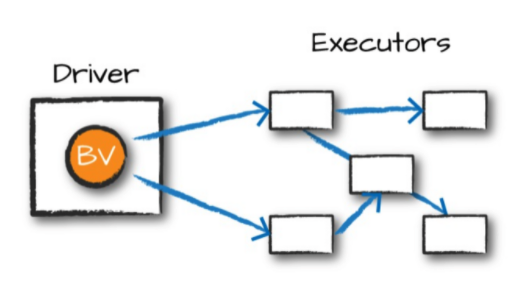

- 스파크 잡이 실행되는 동안 클러스터 내의 모든 서버에 공유할 수 있는 읽기 전용 자원을 설정함
- 변하지 않는 값(불변성 값)을 효율적으로 클러스터 내에 공유
    - 클로저(closure) 함수의 변수로 캡슐화하지 않음
    - 브로드캐스트 변수 사용하지 않는 경우, 태스크에서 드라이버 노드의 변수 사용할 때 클로저 함수 내부에서 단순하게 참조 -> 비효율적
        - 워커 노드에서 여러 번(태스크당 1번) 역직렬화 필요하기 때문에
        - 스파크 잡을 실행할 때마다 워커로 큰 변수를 재전송 해야하기 때문에 -> 브로드캐스트 변수 사용할 경우, 모든 워커 노드에 큰 값을 저장해, 재전송 없이 Spark Action 에서 사용
- 브로드캐스트 변수는 드라이버 프로세스에서 클러스터 모든 익스큐터로 단 한번만 배포
    - (= 클러스터의 모든 머신에 캐시하는 불변성 공유 변수)
    - → 덕분에 데이터를 보다 효율적으로 전송해 직렬화와 역직렬화에 대한 부하를 크게 줄일 수 있음

#### 어느 경우에 브로드캐스트 변수 이용? 
- 데이터가 익스큐터의 가용 메모리에 전부 로드할 수 있는 크기
- 읽기 전용일 경우
    
#### 참고
- 단, 스파크는 동일 스태이지 내에서 실행되는 태스크 간에는 변수를 자동으로 브로드캐스트 변수를 이용해 전달하기 때문에, 여러 스테이지에서 반복적으로 활용하는 경우가 아니라면 명시적으로 브로트캐스트 변수를 지정할 필요는 없음
- RDD, 사용자 정의 함수, Dataset에서 브로드캐스트 변수를 사용할 수 있으며 효과는 동일

In [2]:
### Broadcast Varialbe 
my_collection = "Spark The Definitive Guide : Big Data Processing Made Simple"\
  .split(" ")
words = spark.sparkContext.parallelize(my_collection, 2)

In [4]:
supplementalData = {"Spark":1000, "Definitive":200,
                    "Big":-300, "Simple":100}

In [7]:
suppBroadcast = spark.sparkContext.broadcast(supplementalData)

In [8]:
suppBroadcast.value

In [9]:
words.map(lambda word: (word, suppBroadcast.value.get(word, 0)))\
  .sortBy(lambda wordPair: wordPair[1])\
  .collect()

### 어큐뮬레이터
: 작업 노드에서 드라이버 프로그램으로 보내는 값의 집한 연산에 대해 간단한 문법 제공 작업 수행 중에서 발생하는 일에 대한 개수를 디버깅 목적으로 사용

- 클러스터 내의 모든 서버에 공유할 수 있는 쓰기 공간 제공 (<-> 브로드캐스트 : 읽기 전용)
- 클러스터에서 로우 단위로 안전하게 값을 갱신할 수 있는 변경 가능한 변수 제공
- 트랜스포메이션(RDD를 새로운 RDD로 변환)내부의 다양한 값을 갱신하는데 사용하며, 액션을 처리하는 과정에만 갱신
    - 연산이 실제로 수행될 때 한번 갱신되므로 지연 연산 모델에 영향을 주지 않음
    - RDD의 액션 연산은 어큐뮬레이터의 값을 증가시킬 수만 있을 뿐, 그 값을 참조해서 사용할 수는 없음
- 각 태스트 당 한번만 어큐뮬레이터를 갱신할 수 있으며, 태스크나 잡 스테이지를 재처리하는 경우는 각 태스크의 갱신 작업이 두 번 이상 적용될 수 있음
- 어큐뮬레이터를 사용하지 않고도 reduceByKey 메소드로 가산할 수 있지만, 이 경우 셔플이 발생해 처리 부하가 커짐
    - → 어큐뮬레이터는 내고장성을 보장하면서 효율적인 방식으로 드라이버에 값을 전달할 수 있음

#### 어느 경우에 어큐뮬레이터 이용? 
- 파티션 별로 특정 변수의 값을 추적할 수 있으며, 카운터나 합계를 구하는 용도로 사용
    - → 특정 이벤트의 수를 세거나 관찰하고 싶은 정보를 모두 모아둔다 
- 각 서버에서 에러 정보를 한곳에 모아 디버깅한다
    
#### 참고
- 기본적으로 수치형 어큐뮬레이터를 지원하며, 사용자 정의 어큐뮬레이터를 만들 수 있다
- 이름이 지정된 어큐뮬레이터는 스파크 UI에서 익스큐터 단위로 확인할 수 있다

In [ ]:
# Data load
flights = spark.read\
  .parquet("/data/flight-data/parquet/2010-summary.parquet")

In [ ]:
# accumulator 생성
accChina = spark.sparkContext.accumulator(0)

In [ ]:
def accChinaFunc(flight_row):
  destination = flight_row["DEST_COUNTRY_NAME"]
  origin = flight_row["ORIGIN_COUNTRY_NAME"]
  if destination == "China":
    accChina.add(flight_row["count"])
  if origin == "China":
    accChina.add(flight_row["count"])

In [11]:
# foreach 메서드 사용 
## foreach 메서드는 액션이고, 스파크는 액션에서만 어큐뮬레이터 실행 보장하기 때문
## foreach 메서드는 입력 DataFrame의 매 로우마다 함수를 한 번씩 적용해 어큐뮬레이터 값 증가시킴
flights.foreach(lambda flight_row: accChinaFunc(flight_row))

NameError: name 'flights' is not defined

In [ ]:
accChina.value

# 15. 클러스터에서 스파크 실행하기

스파크에서 코드를 실행할 때 어떤 일이 발생하는지 Araboza!

- 스파크 애플리케이션의 아키텍쳐와 컴포넌트
- 스파크 내/외부에서 실행되는 스파크 애플리케이션의 생애 주기
- 파이프라이닝과 같은 중요한 저수준 실행 속성
- 스파크 애플리케이션을 실행하는데 필요한 사항

## 15.1 스파크 애플리케이션 아키텍쳐
### 스파크 애플리케이션 컴포넌트

- **(프로세스) : 스파크 드라이버/익스큐터 / (물리적 머신에 연결되는 개념) : 클러스터 매니저**
- 스파크 클러스터 : 익스큐터의 상태와 태스크
- 스파크 애플리케이션 : 컴파일된 JAR 파일이나 라이브러리 파일 (수행하려는 코드로 이해함)

- **스파크 드라이버 : 물리적 머신의 '프로세스'이며 클러스터에서 실행중인 애플리케이션의 상태 유지함**
    - 스파크 애플리케이션의 '운전자 역할'을 하는 '프로세스'
    - 사용자가 드라이버 프로그램에 RDD의 생성, 변환, 액션의 로직을 기술하면 -> 애플리케이션 실행 제어하고 스파크 클러스터의 모든 상태 정보 유지
    - 드라이버의 스케줄러를 통해 잡을 태스크 단위로 분할
    - 물리적 컴퓨팅 자원 확보와 익스큐터 실행을 위해 클러스터 매니저와 통신
    - 실제 처리는 드라이버에서 처리되지 않으며, 잡 형태로 클러스터에서 실행됨 (드라이버는 시키고 제어하는 역할)
    - 실행 시점은 드라이버에서 액션 적용을 선언할 때까지 지연됨 (지연 평가)

- **스파크 익스큐터 : 드라이버가 할당한 태스크를 수행하는 '프로세스'**
    - 드라이버가 할당한 태스크를 실행 -> 이에 따라 파티션 단위로 RDD 전체가 분산처리 됨
    - 태스크에 포함된 첫 파티션부터 마지막 파티션까지 순서대로 인스턴스화해서 처리함
    - 태스크 상태와 결과(성공/실패)를 드라이버에 보고 
    - 장애 발생해 태스크 실패하면, 다른 익스큐터로 재실행해 태스크를 재계산
    - 모든 스파크 애플리케이션은 개별 익스큐터 프로세스 사용

- **클러스터 매니저 : 스파크 애플리케이션을 실행할 클러스터 머신(물리적)을 유지**
    - 프로세스가 아닌 물리적인 머신에 연결되는 개념
    - 드라이버(=마스터) 노드(스파크 드라이버랑 다른 개념)/워커 노드 개념 가지고 있음 (헷갈리니 마스터라 부르겠음)
        - 마스터 노드 : 클러스터 내의 계산 리소스 관리 역할을 담당
        - 워커 노드 : CPU 코어와 메모리 할당량 등 계산 리소스 제공, 실제로 할당된 처리 실행
    - 하둡 YARN, 아파치 Mesos, 스파크 Stand alone

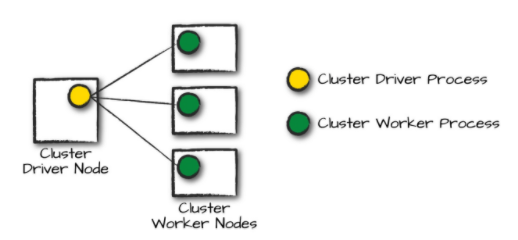

위 그림에서 원들이 클러스터 매니저의 '프로세스', 실행된 상태 아님
- 스파크 애플리케이션을 실제로 실행할 때가 되면 클러스터 매니저에 자원 할당 요청
- 애플리케이션 설정에 따라 스파크 드라이버를 실행할 자원을 포함해 요청 / 익스큐터 자원 요청
- 워커 노드에 **각각 스파크 드라이버/익스큐터 프로세스가 존재**

### 실행 모드

: 스파크 애플리케이션을 실행할 때 요청한 자원을 어느 물리적 위치에서 할 것인가를 결정

- **클러스터 모드 : 클러스터 매니저가 파일/스크립트를 받은 뒤 워커 노드에 스파크 드라이버/익스큐터 프로세스 실행하는 방식**
    - 하나의 워커 노드에 스파크 드라이버(실선 직사각형) 할당
    - 다른 워커 노드에 스파크 익스큐터(점선 직사각형) 할당

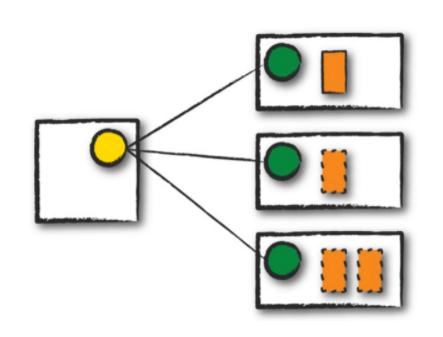

- **클라이언트 모드 : 클라이언트 머신에 스파이크 드라이버가 위치**
    - 클라이언트 머신 : 스파크 드라이버 프로세스 유지하고
    - 클라이언트 매니저 : 익스큐터 프로세스 유지
    - 스파크 드라이버는 클러스터 외부의 머신(클라이언트)에 실행되며 나머지 워커는 클러스터에 위치

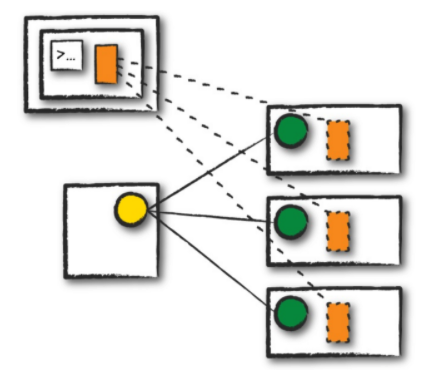

- **로컬 모드 : 모든 스파크 애플리케이션이 단일 머신에서 실행되는 방식**
    - 병렬 처리를 위해 단일 머신의 스레드 활용
    - 스파크를 학습하거나 애플리케이션 테스트, 개발 중인 애플리케이션을 반복실험하는 용도로 사용
    - 운영용 애플리케이션을 실행할 때에는 로컬 모드 사용을 권장하지 않음

## 15.2 스파크 애플리케이션 생애주기 (스파크 외부)
### 클라이언트 요청 -> 시작 -> 실행 -> 완료

- **클라이언트 요청 : 스파크 애플리케이션(컴파일된 JAR이나 라이브러리 = 우리가 입력한 코드)을 제출**
    - 로컬 머신에서 코드가 실행되어 클러스터 마스터 노드에 요청
    - 스파크 드라이버 프로세스의 자원을 함께 요청
    - 클러스터 매니저가 이 요청을 받아들이고 클러스터 노드 중 하나에 드라이버 프로세스를 실행
    - 스파크 잡을 제출한 클라이언트 프로세스는 종료되고 애플리케이션은 클러스터에서 실행

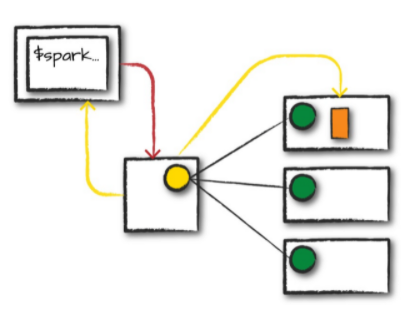

In [ ]:
# 스파크 애플리케이션 제출하기 위해 터미널에서 위와 같은 형태의 명령 실행
./bin/spark-submit \
--class <main-class> \
--master <master-url> \
--deploy-mode cluster \
--conf <key>=<value> \
... # other options <application-jar> \
[application-arguments]

- **시작(launch) : 드라이버 프로세스가 클러스터에 배치되고 사용자 코드를 실행**
    - 반드시 스파크 클러스터(ex. 드라이버와 익스큐터)를 초기화하는 SparkSession을 포함해야 함
    - SparkSession은 클러스터 매니저와 통신해서 익스큐터 프로세스의 실행 요청 
        - (이때 spark-submit을 실행하면서 익스큐터 수와 설정값을 지정할 수 있음)
    - 클러스터 매니저는 익스큐터 프로세스를 시작하고 결과를 응답받아 위치와 관련된 정보를 드라이버 프로세스로 전송
    - 모든 작업이 정상적으로 완료되면 스파크 클러스터가 완성

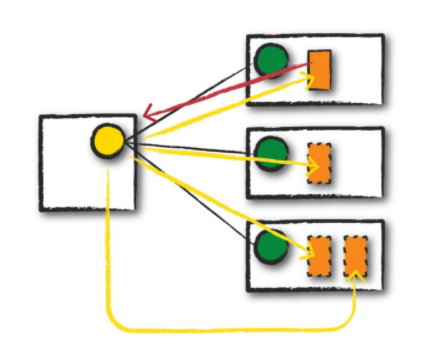

- **실행(Execution) : 스파크 클러스터가 생성되었으므로 코드를 실행**
    - RDD가 데이터를 가진 상태가 됨 (인스턴스화)
    - 마스터 노드와 워커 노드는 코드를 실행하고 데이터를 이동하는 과정에서 서로 통신
    - 마스터 노드는 각 워커에 태스크를 할당함
    - 태스크를 할당받은 워커는 태스크의 상태와 성공/실패 여부를 드라이버에 전송함

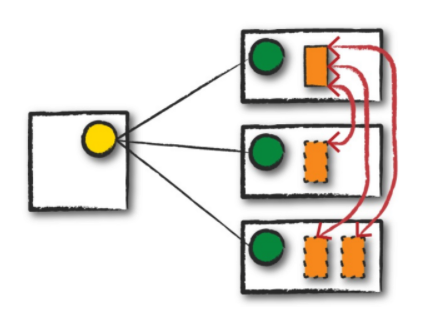

- **완료 : 스파크 애플리케이션 실행이 완료되면 드라이버 프로세스가 성공이나 실패 중 하나의 상태로 종료**
    - 클러스터 매니저는 마스터 노드가 속한 스파크 클러스터의 모든 익스큐터를 종료
    - 이 시점에서 스파크 애플리케이션의 성공/실패 여부를 클러스터 매니저에 요청해 확인할 수 있음

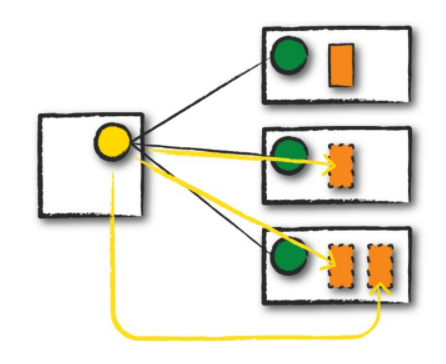

## 15.3 스파크 애플리케이션 생애주기 (스파크 내부)
### SparkSession / 논리적 명령 / 스파크 잡 / 스테이지 / 태스크

- 스파크 애플리케이션은 하나 이상의 스파크 잡으로 구성됨
- 스레드를 사용해 여러 액션을 병렬로 수행하는 경우가 아니라면 애플리케이션의 스파크 잡은 차례대로 실행됨

#### 1. SparkSession
- 모든 스파크 애플리케이션은 가장 먼저 SparkSession 생성
    - 대화형 모드에서는 자동으로 생성되지만, 직접 애플리케이션을 만드는 경우에는 직접 생성해야 함
- SparkSession을 생성하면 스파크 코드를 실행할 수 있음
- SparkSession을 통해 모든 저수준 API, 기존 컨택스트 그리고 관련 설정 정보에 접근할 수 있음

##### SparkContext
: 스파크 클러스터에 대한 연결 나타냄
- SparkContext를 이용하여 스파크의 저수준 API를 사용할 수 있음
- 스파크 과거 버전의 예제는 보통 SparkContext는 일반적으로 sc 변수를 사용함
- RDD, 어큐뮬레이터, 브로드캐스트 변수를 생성하고 코드를 실행할 수 있음
- 대부분 SparkSession으로 SparkContext에 접근할 수 있으므로 명시적으로 SparkContext를 초기화할 필요는 없음
- 직접 초기화하는 가장 일반적인 방법은 getOrCreate 메소드를 사용함

SQLContext
- 과거 버전에서는 SparkContext와 SQLContext 두 개의 컨텍스트가 존재함
- 스파크 2.X 버전에서는 두 컨택스트가 SparkSession으로 단일화함 -> SparkSession 으로 쓰자..
- SparkContext - 스파크 핵심 추상화 개념을 다루는데에 중점
- SQLContext - 스파크 SQL과 같은 고수준 API를 다루는데에 중점

#### 2. 논리적 명령
- 스파크 코드는 트랜스포메이션과 액션으로 구성됨
    - SQL, 저수준 RDD 처리, 머신러닝 알고리즘을 사용해 트랜스포메이션과 액션을 마음대로 구성할 수 있음
- DataFrame과 같은 선언적 명령을 사용하는 방법과, 논리적 명령이 물리적 실행 계획으로 어떻게 변환되는지 이해하는 것이 중요함
- 잡, 스테이지, 태스크를 차례로 따라가야 함

In [ ]:
df1 = spark.range(2, 10000000, 2)
df2 = spark.range(2, 10000000, 4)

step1 = df1.repartition(5)
step12 = df2.repartition(6)

step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])
step4 = step3.selectExpr("sum(id)")
step4.collect() # collect가 action 
# action을 호출하면 개별 스테이지와 태스크로 이루어진 스파크 잡이 실행됨
# -> action 하나 당 하나의 스파크 잡이 실행됨

#### 3. Spark job
- 액션 하나당 하나의 스파크 잡이 생성되며 액션은 항상 결과를 반환
- job은 스테이지로 나뉘며, 스테이지 수는 셔플 작업이 얼마나 많이 발생하는지에 따라 달라짐

In [ ]:
df1 = spark.range(2, 10000000, 2) 
df2 = spark.range(2, 10000000, 4)

step1 = df1.repartition(5)
step12 = df2.repartition(6)

step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])
step4 = step3.selectExpr("sum(id)")
step4.collect() # collect가 action 
# action을 호출하면 개별 스테이지와 태스크로 이루어진 스파크 잡이 실행됨
# -> action 하나 당 하나의 스파크 잡이 실행됨

#### 4. 스테이지
: 다수의 머신에서 동일한 연산을 수행하는 태스크의 그룹

- 스파크는 가능한 많은 태스크(트랜스포메이션)을 동일한 스테이지로 묶으려고 함    
- 스테이지 변경의 기준은 **셔플 작업의 여부**
    - 셔플 : 데이터의 물리적 재분배 과정 ex. DataFrame 정렬이나 키별 데이터 그룹화
    - 셔플을 통해 파티션을 재분배하는 과정 : 데이터 이동이기 때문에 익스큐터 간의 조정 필요 -> **스테이지 변경**
    - 셔플이 끝난 다음 새로운 스테이지 시작하며 최종 결과 계산을 위해 스테이지 실행 순서 추적
- 파티션 수는 매우 중요한 파라미터임 → **클러스터 익스큐터 수보다 파티션 수를 더 크게 지정하는 것이 좋음**
- 로컬 머신에서는 병렬로 처리할 수 있는 태스크 수가 제한적이므로 이 값을 작게 설정해야 함
- 최종 스테이지에서는 드라이버로 결과를 전송하기 전에 파티션마다 개별적으로 수행된 결과를 단일 파티션으로 모으는 작업을 수행

#### 5. 태스크
: **태스크는 데이터 단위(파티션)에 적용되는 연산 단위**
- 스파크의 스테이지는 태스크로 구성됨
- 단일 익스큐터에서 실행할 데이터의 블록과 다수의 트랜스포메이션 조합
- 태스크는 병렬로 진행 가능 -> 간단하게 병렬성을 올리기 위해 파티션 늘리기로 가능 

In [ ]:
df1 = spark.range(2, 10000000, 2)  
## 스테이지 1 : 태스크 8개, range를 사용해 DataFrame 생성하면 8개 파티션 생성 

df2 = spark.range(2, 10000000, 4)
## 스테이지 2 : 태스크 8개, range를 사용해 DataFrame 생성하면 8개 파티션 생성 

# 파티션 재분배 : 데이터 셔플링으로 파티션 수 변경
step1 = df1.repartition(5)
## 스테이지 3 : 태스크 5개, 5개 파티션으로 재분배

step12 = df2.repartition(6)
## 스테이지 4 : 태스크 6개, 6개 파티션으로 재분배

step2 = step1.selectExpr("id * 5 as id")

# 조인(셔플) 수행
step3 = step2.join(step12, ["id"])
## 스테이지 5 : 태스크 200개, 스파크 SQL 셔플 파티션 기본값 200 -> 200개의 셔플 파티션 생성 
## 변경 가능, 클러스터의 익스큐터 수보다 파티션 수를 더 크게 지정하는 것이 좋음
## 스테이지 6 : 태스크 1개, 드라이버로 결과를 전송하기 전에 파티션마다 개별적으로 수행되 결과 단일 파티션으로 모음


step4 = step3.selectExpr("sum(id)")
step4.collect() # collect가 action 
# action을 호출하면 개별 스테이지와 태스크로 이루어진 스파크 잡이 실행됨
# -> action 하나 당 하나의 스파크 잡이 실행됨

## 15.4 세부 실행 과정
- 스테이지와 태스크의 중요한 특성
    - **스파크는 map 연산 이후 다른 map 연산이 이어진다면 함께 실행할 수 있도록 스테이지와 태스크를 자동으로 연결함**
    - **스파크는 모든 셔플을 작업할 때 데이터를 안정적인 저장소(디스크)에 저장하므로 여러 잡에서 재사용할 수 있음**

### 파이프라이닝
: - 스파크 핵심 요소 중 하나로 최적화 기법 : 하둡의 맵리듀스와 달리 메모리나 디스크에 데이터 쓰기 전에 최대한 많은 단계를 수행 
-> 최적화 기법 중 하나로, **노드 간의 데이터 이동 없이** 데이터를 직접 공급할 수 있는 연산만 모아 **태스크의 단일 스테이지**로 만듬

- 예를 들어 map, filter, map 순서로 실행되는 RDD 기반의 프로그램을 개발했다면 일련의 과정을 태스크의 단일 스테이지로 만듬
- 파이프라인으로 구성된 연산 작업은 단계별(ex. map, filter, map)로 메모리나 디스크에 중간 기록하는 방식보다 훨씬 처리 속도가 빠름
- select, filter, select를 수행하는 DataFrame이나 SQL 연산에서도 동일한 파이프라이닝 유형이 적용
- 자동으로 적용되서, spark UI로 확인하면 다수의 RDD 또는 DataFrame 연산이 하나의 스테이지로 파이프라이닝 됨을 확인

### 셔플 결과 저장 (shuffle persistence)
- 스파크가 노드 간 복제를 유발하는 연산 실행할 경우, 엔진에서 파이프라이닝 수행하지 못하므로 네트워크 셔플이 발생